# Preprocessing

## Config

In [1]:
STATE_CLASSES = 10
N_FRAMES = 10
BATCH_SIZE = 8
EPOCHS = 100
HISTORY = 'h2_100'

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Individual Models FXAI/

/content/drive/MyDrive/Individual Models FXAI


## Env setup

In [4]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
#!pip install -Uq "tensorflow>=2.10.0"
# !pip install --quiet --upgrade tensorflow-federated
!pip install remotezip tqdm opencv-python einops
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7933 sha256=b71f2f00ebdd674d14e7e62b51caaef0609c8f0700e7417ab90f7717a43d0a20
  Stored in directory: /root/.cache/pip/wheels/fc/76/04/beed1a6df4eb7430ee13c3900746edd517e5e597298d1f73f3
Successfully built remotezip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: kera

In [5]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [6]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

# extras
from sklearn.model_selection import train_test_split
import keras
from keras.layers.convolutional import ( Conv2D, MaxPooling2D, AveragePooling2D)
from keras.layers import (    Input,    Activation,    Dense,    Flatten)
from keras.layers import add
from keras.layers import LayerNormalization

from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import np_utils

## Load data

In [7]:
NPZ_Name = 'Data/Videos_Database_20_Robot_WebCam_50_overall_database.npz'
Database_Used = np.load(NPZ_Name)
Sessions = Database_Used['Session']

In [8]:
# create a list of the unique sessions to become the client_ids
client_ids = np.unique(Sessions)

### Get into format of classes and video files

In [9]:
# Using code from tff to sort data
def create_fg_dataset(client_ids, Database_used_col, categorical, categories):
  dataset = [[] for _ in range(categories)]
  dataset_train = [[] for _ in range(categories)]
  dataset_test = [[] for _ in range(categories)]
  for session in client_ids:
    # find the indices of the current session in the Sessions column of Database_Used
    session_indices = np.where(Sessions == session)[0]

    # get the X_train data for the current session
    session_X = Database_Used['X_train'][session_indices]
    # grab the training data for the necessary hierarchy
    session_Y = Database_Used[Database_used_col][session_indices]
    # if using categorical data, reshape the data for the model into one-hot encoded
    # if categorical==True:
    #   session_Y = np_utils.to_categorical(session_Y, categories)

    '''
    Here is where we need to further split on classes
    '''
    # The session dataset will be a list of lists
    # The first index will represent the class
    # The second index will represent the frames in the session belonging to that class

    # get the unique classes in the session
    session_classes = np.unique(session_Y)

    # for each class in the session
    for session_class in session_classes:
        # get the indices of the current class
        class_indices = np.where(session_Y == session_class)[0]
        # get the X_train data for the current class
        class_X = session_X[class_indices]
        # append the class data to the dataset, using the class as the index
        dataset[session_class].append(class_X)

  # create a train/test split of the dataset for each class
  for i in range(categories):
      dataset_train[i], dataset_test[i] = train_test_split(dataset[i], test_size=0.2)

  return dataset_train, dataset_test

'''
The dataset is a list of lists of lists
index 0: class
index 1: video selection
index 2: frame selection
'''

'\nThe dataset is a list of lists of lists\nindex 0: class\nindex 1: video selection\nindex 2: frame selection\n'

In [10]:
X_train, X_test = create_fg_dataset(client_ids, 'Y_train_State', True, STATE_CLASSES)

### Shorten the video files appropriately

In [11]:
def frames_from_video_file(video_frames, n_frames, frame_step = 15):

  # Read each video frame by frame
  result = []

  video_length = len(video_frames)

  # Calculate the minimum required length for the video to get the desired
  # number of frames considering the frame step
  need_length = 1 + (n_frames - 1) * frame_step

  # Either start at the beginning or at a random point between the beginning
  # and the latest possible point to ensure the desired number of frames
  # can be gathered
  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  # Begin collecting the frames
  frame = video_frames[start]
  result.append(frame)

  current = start

  for _ in range(n_frames - 1):
    current += frame_step
    # If we have run out of space in the array, just fill it with black
    if current >= video_length:
      result.append(np.zeros_like(result[0]))
    else:
      frame = video_frames[current]
      result.append(frame)

  return result

In [12]:
# Need to get all the frames sorted pre-FrameGenerator
for i in range(len(X_train)):
  for j in range(len(X_train[i])):
    X_train[i][j] = frames_from_video_file(X_train[i][j], N_FRAMES)
    X_train[i][j] = np.array(X_train[i][j])

for i in range(len(X_test)):
  for j in range(len(X_test[i])):
    X_test[i][j] = frames_from_video_file(X_test[i][j], N_FRAMES)
    X_test[i][j] = np.array(X_test[i][j])

In [13]:
X_train[0][0].shape

(10, 50, 50, 3)

In [14]:
class FrameGenerator:
  def __init__(self, dataset, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.dataset = dataset
    self.training = training
    self.class_names = [i for i in range(len(dataset))]

  def get_videos_and_labels(self):
    videos = []
    labels = []
    for i in range(len(self.dataset)):
      for j in range(len(self.dataset[i])):
        videos.append(self.dataset[i][j])
        labels.append(i)
    return videos, labels

  def __call__(self):
    # No longer using the training boolean to shuffle data, not an issue just
    # something to be aware of

    videos, labels = self.get_videos_and_labels()

    pairs = list(zip(videos, labels))

    if self.training:
      random.shuffle(pairs)

    for video_frames, label in pairs:
      yield video_frames, label

In [15]:
# Test out the FrameGenerator
fg = FrameGenerator(X_train)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 50, 50, 3)
Label: 0


In [16]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(X_train, training=True),
                                          output_signature = output_signature)

In [17]:
# Making sure they are shuffled
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)


In [18]:
# Create test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(X_test, training=True),
                                          output_signature = output_signature)

In [19]:
# # Print the shapes of the data
# train_frames, train_labels = next(iter(train_ds))
# print(f'Shape of training set of frames: {train_frames.shape}')
# print(f'Shape of training labels: {train_labels.shape}')

# test_frames, test_labels = next(iter(test_ds))
# print(f'Shape of validation set of frames: {test_frames.shape}')
# print(f'Shape of validation labels: {test_labels.shape}')

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [21]:
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [22]:
# train_frames, train_labels = next(iter(train_ds))
# print(f'Shape of training set of frames: {train_frames.shape}')
# print(f'Shape of training labels: {train_labels.shape}')

# test_frames, test_labels = next(iter(test_ds))
# print(f'Shape of validation set of frames: {test_frames.shape}')
# print(f'Shape of validation labels: {test_labels.shape}')

# Video Classification

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

**Note**: Use TensorFlow 2.10 to run this tutorial. Versions above TensorFlow 2.10 may not run successfully.

In [23]:
# !pip install remotezip tqdm opencv-python einops
# # Install TensorFlow 2.10
# !pip install tensorflow==2.10.0

In [24]:



import einops


import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import layers

## Create the model

In [25]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 50
WIDTH = 50

In [26]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [27]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [28]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [29]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [30]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [31]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [32]:
frames, label = next(iter(train_ds))
model.build(frames)

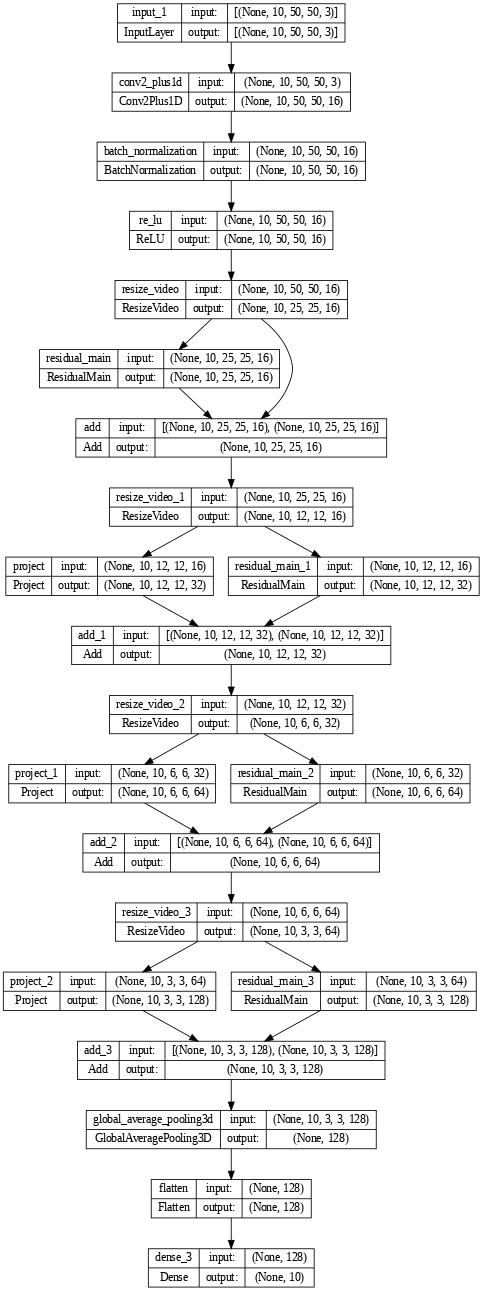

In [33]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [34]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [35]:
history = model.fit(x = train_ds,
                    epochs = EPOCHS,
                    validation_data = test_ds)

Epoch 1/100
23/23 [==============================] - 9s 241ms/step - loss: 2.2710 - accuracy: 0.1793 - val_loss: 2.0088 - val_accuracy: 0.2174
Epoch 2/100
23/23 [==============================] - 4s 176ms/step - loss: 2.0385 - accuracy: 0.2228 - val_loss: 1.9631 - val_accuracy: 0.2174
Epoch 3/100
23/23 [==============================] - 4s 179ms/step - loss: 1.8663 - accuracy: 0.2772 - val_loss: 1.8929 - val_accuracy: 0.1522
Epoch 4/100
23/23 [==============================] - 4s 175ms/step - loss: 1.7788 - accuracy: 0.2663 - val_loss: 1.6921 - val_accuracy: 0.2391
Epoch 5/100
23/23 [==============================] - 4s 176ms/step - loss: 1.6999 - accuracy: 0.2826 - val_loss: 1.6608 - val_accuracy: 0.2174
Epoch 6/100
23/23 [==============================] - 4s 180ms/step - loss: 1.6601 - accuracy: 0.3043 - val_loss: 1.6328 - val_accuracy: 0.2826
Epoch 7/100
23/23 [==============================] - 4s 181ms/step - loss: 1.5978 - accuracy: 0.3587 - val_loss: 1.6064 - val_accuracy: 0.3043

In [36]:
!cd /content/drive/MyDrive/video-classification

In [37]:
import pickle

# Save the history object using pickle
with open('/content/drive/MyDrive/video-classification/logs/' + HISTORY + '.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [38]:
# Load the history object back
with open('/content/drive/MyDrive/video-classification/logs/' + HISTORY + '.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

print(loaded_history['loss'])        # Training loss values
print(loaded_history['val_loss'])    # Validation loss values
print(loaded_history['accuracy'])    # Training accuracy values
print(loaded_history['val_accuracy'])# Validation accuracy values

[2.2710494995117188, 2.038459539413452, 1.8663101196289062, 1.7787891626358032, 1.6999245882034302, 1.6600650548934937, 1.5977529287338257, 1.627655029296875, 1.6734559535980225, 1.5480618476867676, 1.5251879692077637, 1.462772250175476, 1.472884178161621, 1.5046597719192505, 1.387933611869812, 1.3900611400604248, 1.420034646987915, 1.3895409107208252, 1.3362270593643188, 1.3498361110687256, 1.331080675125122, 1.3149850368499756, 1.3037930727005005, 1.2432949542999268, 1.1967706680297852, 1.2006843090057373, 1.1686506271362305, 1.0788027048110962, 1.0406403541564941, 1.1122615337371826, 1.0248115062713623, 0.9792787432670593, 1.035352349281311, 0.9299274682998657, 0.9349280595779419, 0.9050150513648987, 0.892078161239624, 0.9094729423522949, 0.8892730474472046, 0.9557352662086487, 0.9543332457542419, 0.8262529969215393, 0.8227073550224304, 0.7504330277442932, 0.729470431804657, 0.7394546270370483, 0.748361349105835, 0.9102177023887634, 0.7402678728103638, 0.712893009185791, 0.677918672

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

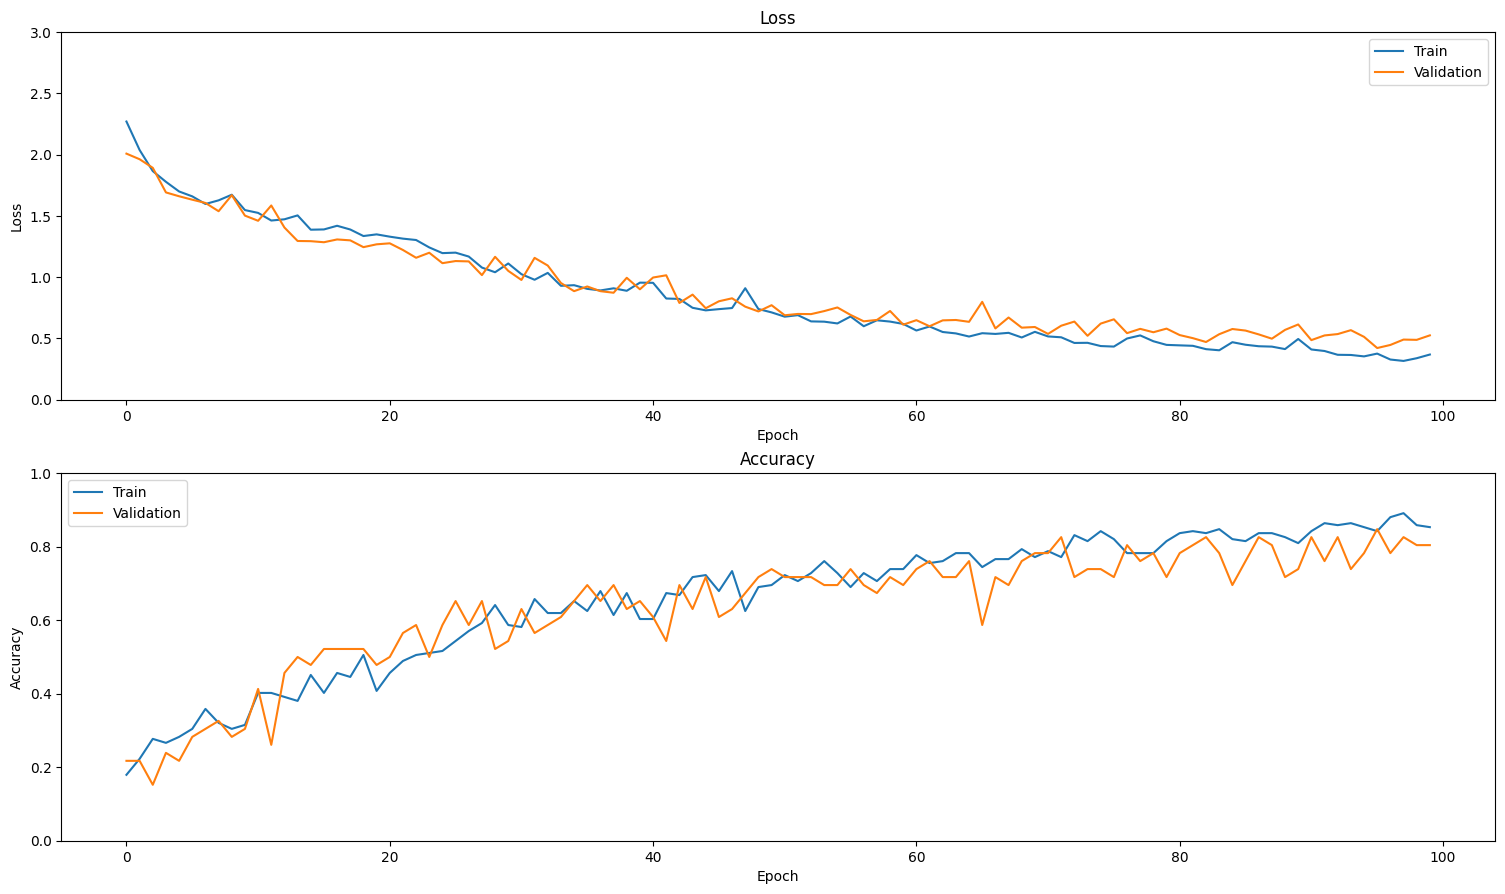

In [39]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset.

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data.

In [40]:
model.evaluate(test_ds, return_dict=True)

6/6 [==============================] - 0s 41ms/step - loss: 0.5254 - accuracy: 0.8043


{'loss': 0.5253976583480835, 'accuracy': 0.804347813129425}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [41]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [42]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [43]:
fg = FrameGenerator(X_train, training=True)
labels = fg.class_names

23/23 [==============================] - 2s 39ms/step


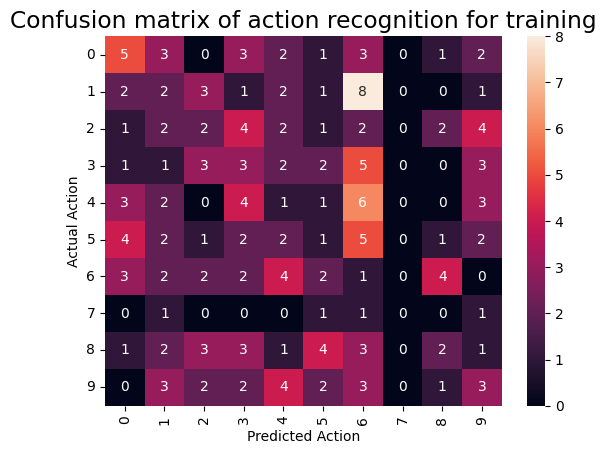

In [44]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

6/6 [==============================] - 0s 40ms/step


The precision and recall values for each class can also be calculated using a confusion matrix.

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall

In [ ]:
from google.colab import runtime
runtime.unassign()